In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# Загрузка данных
DATA_DIR = '/content/gdrive/MyDrive/датасеты/chest_xray/train'
CATEGORIES = ["NORMAL", "PNEUMONIA"]
IMG_SIZE = 150

data = []

def create_data(): 
    for category in CATEGORIES: # для каждой категории
        path = os.path.join(DATA_DIR, category) # находим путь к изображениям
        class_num = CATEGORIES.index(category) # задаем номер класса (NORMAL - 0, PNEUMONIA - 1)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # читаем изображения в градации серого
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # меняем размер
                data.append([resized_array, class_num]) # добавляем в массив data изображение и класс
            except Exception as e:
                pass

create_data()
random.shuffle(data) # перемешиваем данные

In [ ]:
# отделяем метки от изображений
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# преобразуем в массив numpy

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

# разделяем на обучающую и тестовую выборку 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# приводим все значения пикселей в диапазон между 0 и 1

X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# определяем архитектуру модели
model = tf.keras.Sequential([
  layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [ ]:
from keras.metrics import Recall
import keras.backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

# регистрация метрики
custom_objects = {'recall': recall, 'precision': precision, 'f1': f1}

keras.utils.get_custom_objects().update(custom_objects)

In [ ]:
# компилируем модель

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', f1, recall, precision])

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50

train_datagen = ImageDataGenerator()


In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
146/146 [==============================] - 240s 2s/step - loss: 0.2873 - accuracy: 0.8806 - f1: 0.9220 - recall: 0.9536 - precision: 0.9019 - val_loss: 0.2454 - val_accuracy: 0.9050 - val_f1: 0.9366 - val_recall: 0.9936 - val_precision: 0.8881
Epoch 2/50
146/146 [==============================] - 232s 2s/step - loss: 0.1400 - accuracy: 0.9506 - f1: 0.9654 - recall: 0.9698 - precision: 0.9626 - val_loss: 0.1357 - val_accuracy: 0.9452 - val_f1: 0.9611 - val_recall: 0.9609 - val_precision: 0.9628
Epoch 3/50
146/146 [==============================] - 224s 2s/step - loss: 0.1170 - accuracy: 0.9574 - f1: 0.9704 - recall: 0.9738 - precision: 0.9686 - val_loss: 0.1364 - val_accuracy: 0.9443 - val_f1: 0.9603 - val_recall: 0.9633 - val_precision: 0.9588
Epoch 4/50
146/146 [==============================] - 228s 2s/step - loss: 0.1101 - accuracy: 0.9574 - f1: 0.9702 - recall: 0.9730 - precision: 0.9692 - val_loss: 0.1594 - val_accuracy: 0.9443 - val_f1: 0.9615 - val_recall: 0.9860 - va

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
# Оценка модели
loss, acc, f1, recall, precision = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test Accuracy:, {acc:.4f}")
print(f"Test F1-score:, {f1:.4f}")
print(f"Test recall: {recall:.4f}")
print(f"Test Precision:, {precision:.4f}")

37/37 [==============================] - 13s 351ms/step - loss: 0.1271 - accuracy: 0.9555 - f1: 0.9686 - recall: 0.9762 - precision: 0.9622
Test loss: 0.1271
Test Accuracy:, 0.9555
Test F1-score:, 0.9686
Test recall: 0.9762
Test Precision:, 0.9622


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, metric_list, title):
    """
    Функция для построения графиков метрик.

    Parameters:
        history (keras.callbacks.History): История обучения модели.
        metric_list (list): Список с именами метрик.
        title (str): Название графика.
    """
    epochs_range = range(1, len(history.history[metric_list[0]]) + 1)

    fig, axes = plt.subplots(nrows=len(metric_list), ncols=1, figsize=(8, 20))

    for i, metric in enumerate(metric_list):

        ax = axes[i]
        ax.set_title(metric)

        # График изменения на обучающих и проверочных данных
        train_metric = history.history[metric]
        val_metric = history.history['val_' + metric]

        ax.plot(epochs_range, train_metric, label='Training')
        ax.plot(epochs_range, val_metric, label='Validation')
        ax.legend(loc='lower right')

    plt.suptitle(title)
    plt.show()

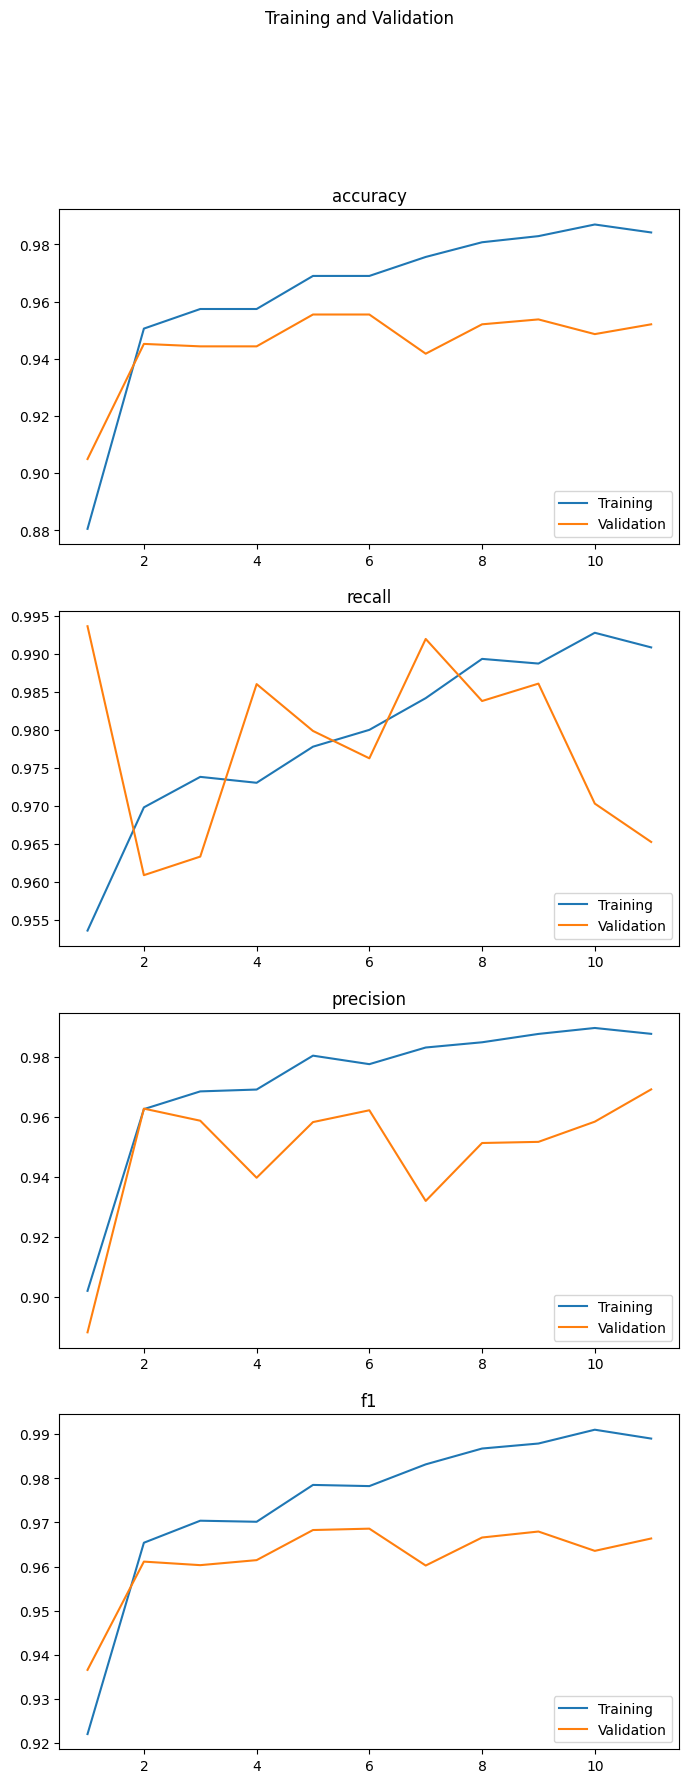

In [ ]:
metric_list = ['accuracy', 'recall', 'precision', 'f1']

plot_metrics(history, metric_list, 'Training and Validation')

In [ ]:
# загружаем новое изображение легких и определяем, относится ли оно к здоровым или к пневмонии
img_path = '/content/IM-0025-0001.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = normalization_layer(img_array)
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
  print('Pneumonia')
else:
  print('Healthy')

1/1 [==============================] - 0s 31ms/step
Healthy
